In [1]:
import requests
from PIL import  Image
from urllib.request import urlopen
puppy_path = "https://th-thumbnailer.cdn-si-edu.com/pl7tMO37jADJMfZ8T1DuIRDaBbc=/fit-in/1600x0/https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer/db/d6/dbd616d4-f52c-43cb-a9c2-4f77a5dcb2d3/eiffel-tower-night.jpg"


image1 = Image.open(urlopen(puppy_path)).convert("RGB")
caption = "glowing Eiffel tower at night"

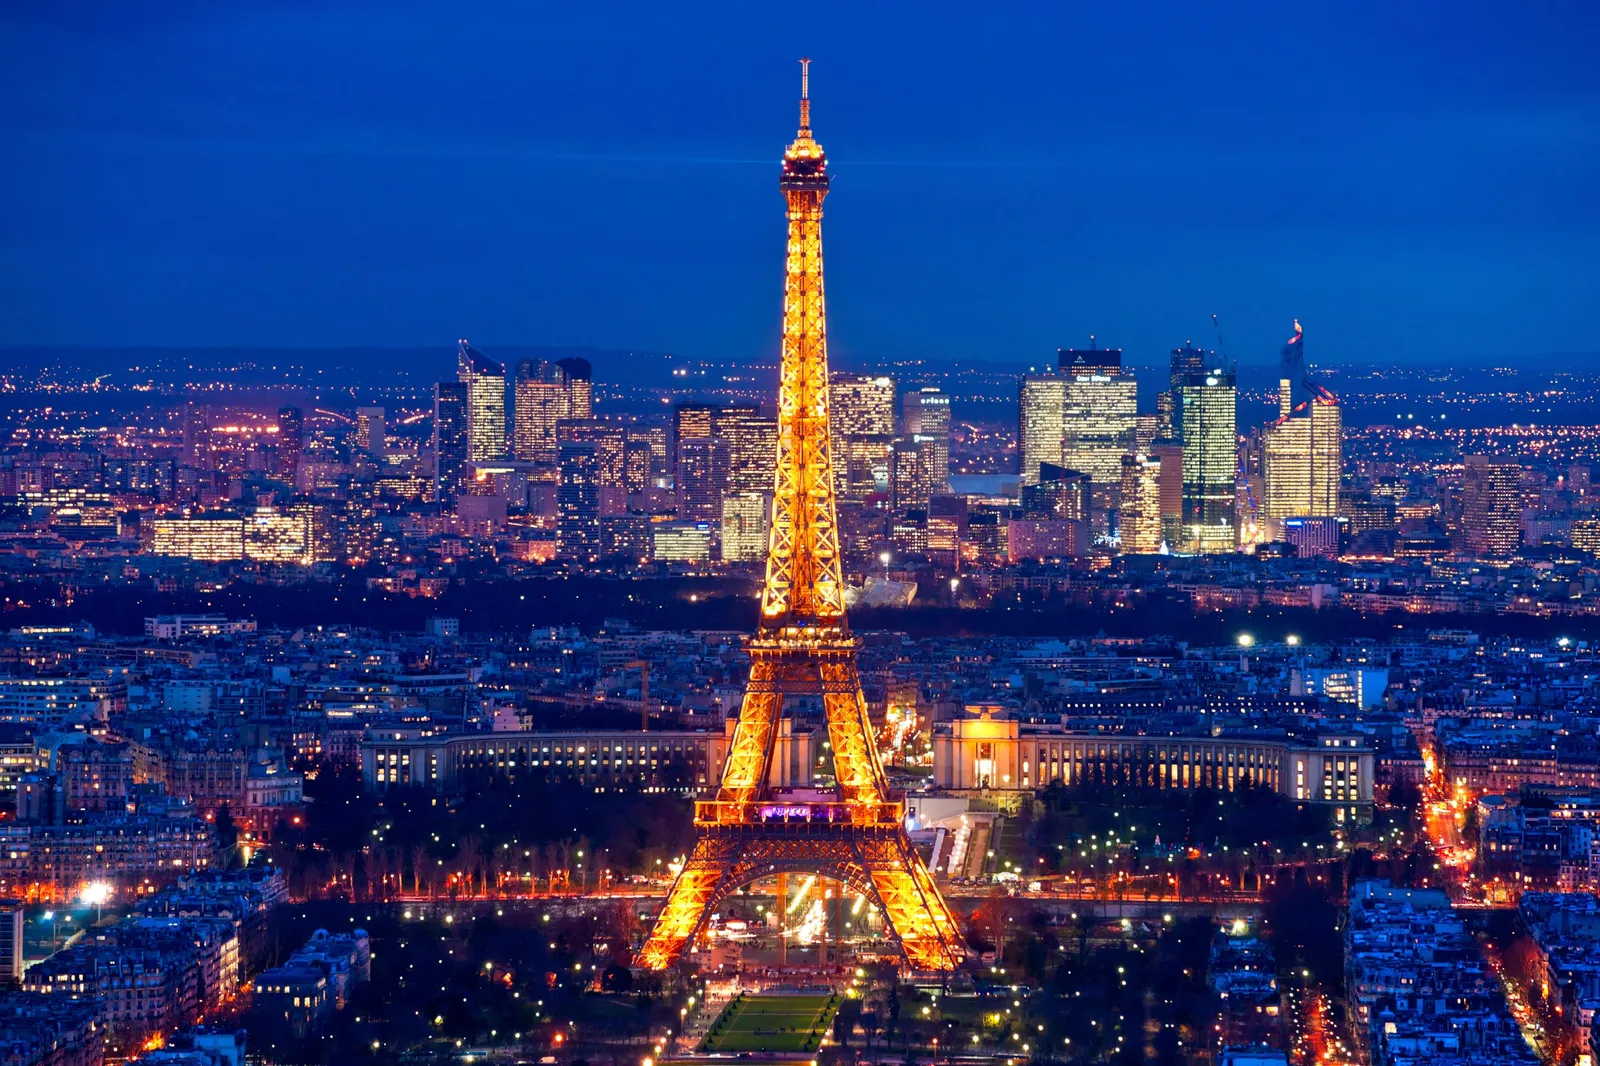

In [2]:
image1

In [3]:
from transformers import CLIPTokenizer, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

clip_tokenizer = CLIPTokenizer.from_pretrained(model_id)
clip_processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
inputs = clip_tokenizer(caption, return_tensors='pt')
inputs

{'input_ids': tensor([[49406, 18437, 29720,  4730,   536,   930, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [5]:
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'glowing</w>',
 'eiffel</w>',
 'tower</w>',
 'at</w>',
 'night</w>',
 '<|endoftext|>']

In [6]:
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [7]:
processed_image = clip_processor(
    text = None, images = image1, return_tensors = "pt"
)["pixel_values"]

processed_image.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

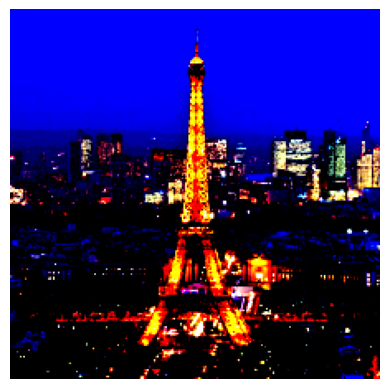

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim-1, -1, -1))
img = np.einsum("ijk->jik", img)

plt.imshow(img)
plt.axis("off")

In [9]:
img_embedding = model.get_image_features(processed_image)
img_embedding.shape

torch.Size([1, 512])

In [10]:
text_embedding /= text_embedding.norm(dim = -1, keepdim =True)
img_embedding /= img_embedding.norm(dim = -1, keepdim =True)

In [11]:
text_embedding = text_embedding.detach().cpu().numpy()
img_embedding = img_embedding.detach().cpu().numpy()
score = np.dot(text_embedding, img_embedding.T)
score

array([[0.2836737]], dtype=float32)

In [12]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('clip-ViT-B-32')
image_embeddings = model.encode(image1, convert_to_tensor=True)
text_embeddings = model.encode(caption, convert_to_tensor=True)

sim_matrix = util.cos_sim(text_embeddings, image_embeddings)
sim_matrix

tensor([[0.2837]], device='cuda:0')

## BLIP

In [13]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

blip_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
  )
  (qf

In [14]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                                 Param #
Blip2ForConditionalGeneration                                          24,576
├─Blip2VisionModel: 1-1                                                --
│    └─Blip2VisionEmbeddings: 2-1                                      363,264
│    │    └─Conv2d: 3-1                                                829,312
│    └─Blip2Encoder: 2-2                                               --
│    │    └─ModuleList: 3-2                                            984,756,864
│    └─LayerNorm: 2-3                                                  2,816
├─Blip2QFormerModel: 1-2                                               --
│    └─LayerNorm: 2-4                                                  1,536
│    └─Dropout: 2-5                                                    --
│    └─Blip2QFormerEncoder: 2-6                                        --
│    │    └─ModuleList: 3-3                                            105,136

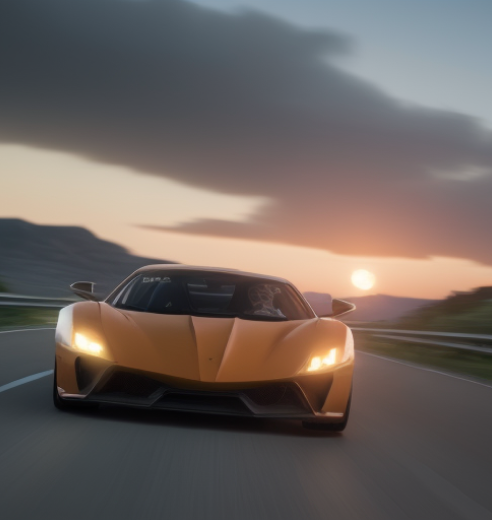

In [15]:
car_path = "https://raw.githubusercontent.com/HandsonLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")
image

In [16]:
inputs = blip_processor(image,return_tensors = 'pt').to(device,torch.float16)
inputs["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [17]:
blip_processor.tokenizer

GPT2TokenizerFast(name_or_path='Salesforce/blip2-opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50265: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [18]:
text = "Her vocalization was remarkably melodic"

token_ids = blip_processor(image, text=text, return_tensors= "pt")
token_ids = token_ids.to(device,torch.float16)["input_ids"][0]
tokens =  blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 'Ġvocal',
 'ization',
 'Ġwas',
 'Ġremarkably',
 'Ġmel',
 'odic']

In [19]:
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

['<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '<image>',
 '</s>',
 'Her',
 '_vocal',
 'ization',
 '_was',
 '_remarkably',
 '_mel',
 'odic']

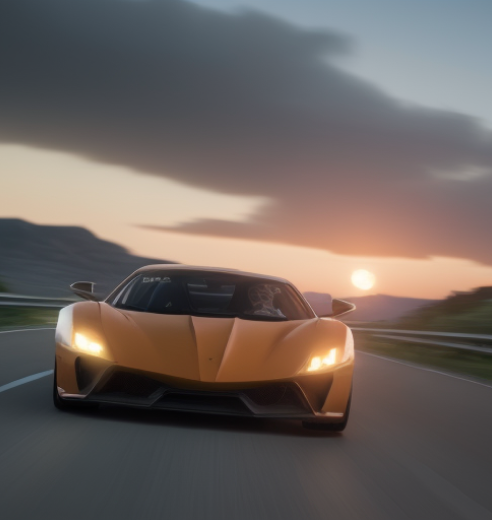

In [20]:
image = Image.open(urlopen(car_path)).convert("RGB")
inputs = blip_processor(image,return_tensors = 'pt').to(device,torch.float16)
image

In [38]:
generated_ids = model.generate(**inputs, max_new_tokens = 20)

generated_text = blip_processor.batch_decode(
    generated_ids, skip_spacial_tokens = True
)
generated_text = generated_text[0].strip()
generated_text

'<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image></s>Her vocalization was remarkably melodic and rhythmic, and her voice was a perfect match for the music'